In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from utils import preprocess

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
DATA_PATH = os.path.join('../data')
TRAIN_FILE = os.path.join(DATA_PATH, 'train.csv')
TEST_FILE = os.path.join(DATA_PATH, 'test.csv')

In [5]:
train_features = preprocess(TRAIN_FILE)

In [6]:
train_features['bearing'] = train_features['bearing'] * 360
train_features.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'quarter', u'weekday',
       u'holiday', u'st_dist', u'h_dist', u'travel_dir', u'bearing',
       u's_pickup_latitude', u's_pickup_longitude', u's_dropoff_latitude',
       u's_dropoff_longitude', u'flag', u'month_end', u'month_start'],
      dtype='object')

In [7]:
features = train_features[[u'vendor_id', 
       u'passenger_count', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'weekday',
       u'holiday', u'st_dist', u'h_dist', u'bearing',
       u's_pickup_latitude', u's_pickup_longitude', u's_dropoff_latitude',
       u's_dropoff_longitude', u'flag', u'month_end', u'month_start']].astype('float64').as_matrix()
targets = train_features['trip_duration'].as_matrix()

In [8]:
print features.shape
print targets.shape

(1458644, 20)
(1458644,)


In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [11]:
from matplotlib import pyplot as plt

In [42]:
samples_idx = np.random.choice(features.shape[0], 500000, replace=False)

In [43]:
X = features[samples_idx]
y = targets[samples_idx]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)
print X.shape, X_test.shape
print y.shape, y_test.shape

(80000, 20) (20000, 20)
(80000,) (20000,)


In [44]:
def scorer(est, X, y):
    y_hat = est.predict(X)
    loss = []
    for yi, yj in zip(y, y_hat):
        diff = np.log(yi + 1.0) - np.log(yj + 1.0)
        loss.append(diff ** 2)
    return -np.sqrt(np.mean(loss))

In [45]:
from sklearn.ensemble import AdaBoostRegressor

In [46]:
tree = DecisionTreeRegressor(criterion='mse', max_features=None, 
                             max_depth=40, min_samples_leaf=50)
regressor = AdaBoostRegressor(base_estimator=tree, n_estimators=150,
                              learning_rate=1.0, loss='square')

In [47]:
kf = KFold(n_splits=10, shuffle=True)

val_loss = []
cv_round = 1

for train_idx, valid_idx in kf.split(X):
    regressor.fit(X[train_idx], y[train_idx])
    score = scorer(regressor, X[valid_idx], y[valid_idx]) * -1
    print 'CV Round: {}, Validn. loss: {}'.format(cv_round, score)
    val_loss.append(score)
    cv_round += 1

CV Round: 1, Validn. loss: 0.458815361397
CV Round: 2, Validn. loss: 0.486402741091
CV Round: 3, Validn. loss: 0.486570649873
CV Round: 4, Validn. loss: 0.486672509324
CV Round: 5, Validn. loss: 0.474148824516
CV Round: 6, Validn. loss: 0.47256744631
CV Round: 7, Validn. loss: 0.48253893019
CV Round: 8, Validn. loss: 0.483489261268
CV Round: 9, Validn. loss: 0.476742226988
CV Round: 10, Validn. loss: 0.470324271348


In [48]:
def rmsle(y, y_hat):
    loss = []
    for yi, yj in zip(y, y_hat):
        diff = np.log(yi + 1.0) - np.log(yj + 1.0)
        loss.append(diff ** 2)
    return np.sqrt(np.mean(loss))

In [49]:
train_errors = []
test_errors = []

for _y, _yh in zip(regressor.staged_predict(X), regressor.staged_predict(X_test)):
    train_error = rmsle(_y, y)
    test_error = rmsle(_yh, y_test)
    train_errors.append(train_error)
    test_errors.append(test_error)

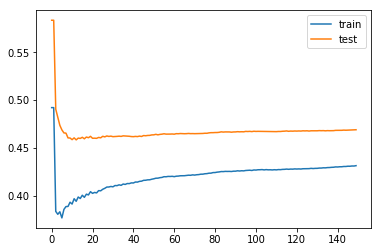

In [50]:
plt.plot(range(len(regressor.estimators_)), train_errors, label='train')
plt.plot(range(len(regressor.estimators_)), test_errors, label='test')
plt.legend()
plt.show()

In [21]:
test_features = preprocess(TEST_FILE)

In [22]:
test_features['bearing'] = test_features['bearing'] * 360

In [23]:
test_ = test_features[[u'vendor_id', 
       u'passenger_count', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'weekday',
       u'holiday', u'st_dist', u'h_dist', u'bearing',
       u's_pickup_latitude', u's_pickup_longitude', u's_dropoff_latitude',
       u's_dropoff_longitude', u'flag', u'month_end', u'month_start']]

In [24]:
pred = regressor.predict(test_)

In [27]:
with open('predictions.txt', 'w') as _file:
    _file.write('id,trip_duration\n')
    for tid, p in zip(test_features['id'], pred):
        _file.write('{},{}\n'.format(tid, p))

In [28]:
scorer(regressor, X_test, y_test)

-0.45365612936521915